In [65]:
from functions import (
    interpOntoEvenGrid,
    makeArtificialSlowRots,
    crossCorrelate,
    measureFWHM,
    get_spectrum_orders,
    interp_vsini,
    prepare_model,
    limbdark
)

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import os
import json
from typing import List

In [2]:
def make_fig(
    target_info,
    template_info,
    order,
    savedir=None,
    savekwargs=None,
    shift=0,
    r=None,
    full_ccf=True,
    output=False,
    model=False,
    model_kwargs=None,
    show_ccf_peak=False,
    diagnose_ccf=False
):
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 16))
    
    if isinstance(target_info['path'], list):
        
        fluxlist = list()
        for p in target_info['path']:
            
            fastdict = get_spectrum_orders(p, orders=[order])
            fluxlist.append(fastdict[f'flux{order}'])
        
        fast = {
            f'wave{order}' : fastdict[f'wave{order}'],
            f'flux{order}' : np.median(fluxlist, axis=0),
        }
    
    else:
        
        fast = get_spectrum_orders(target_info['path'], orders=[order])
        

    if model:
        
        slowwave, slowflux, peaks, R = prepare_model(
            template_info['path'],
            fast[f'wave{order}'],
            fast[f'flux{order}'],
            **model_kwargs,
        )
    
    else:
    
        slow = get_spectrum_orders(template_info['path'], orders=[order])

        slowwave = slow[f'wave{order}']
        slowflux = slow[f'flux{order}']
    
    ### Spectra plot ###
    
    fastwave = fast[f'wave{order}']
    fastflux = fast[f'flux{order}'] / np.nanmedian(slowflux) # normalizes to roughly the same continuum as template
    
    if r is not None:
        
        if len(np.shape(r)) == 1:
            ax1.set_xlim(*r)
        elif len(np.shape(r)) == 2:
            ax1.set_xlim(*r[0])
            ax1.set_ylim(*r[1])
        
        s = f"[{order}*]"
        
    else:
        s = f"[{order}]"
        
    if shift < 0:
        mm1 = slice(None, shift-1)
        mm2 = slice(shift-1, None)
    elif shift > 0:
        mm1 = slice(shift+1, None)
        mm2 = slice(None, shift+1)
    else:
        mm1 = slice(None, None)
        mm2 = slice(None, None)

    ax1.plot(
        fastwave,
        fastflux, 
        c='blue', 
        ls='-',
        linewidth=1.5, 
        alpha=1.0,
        label=f"Target ({target_info['name']}) {s}\n{target_info['other']}"
    )

    if model:
        ax1.scatter(fastwave[peaks], fastflux[peaks], marker='X', s=50, color='darkorange', zorder=100)
    
    ax1.plot(
        slowwave[mm1], 
        np.concatenate([slowflux[-shift:], slowflux[:-shift]])[mm1],
        c='k', 
        linestyle='--', 
        linewidth=1.5, 
        alpha=1.0,
        zorder=-1,
        label=f"Template ({template_info['name']}) {s}\n{template_info['other']}"
    )

    ax1.plot(
        slowwave[mm2], 
        np.concatenate([slowflux[-shift:], slowflux[:-shift]])[mm2],
        c='k', 
        linestyle=':', 
        linewidth=1.5, 
        alpha=1.0,
        zorder=-1,
    )
    
    ax1.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2))
    ax1.set_xlabel("$\lambda$ ($\mu$m)")
    ax1.set_ylabel("Normalized Flux")
    
    ### CCF plot ###
    
    # newslowwave, newslowflux = interpOntoEvenGrid(slow[f'wave{order}'], slow[f'flux{order}'])
    newslowwave, newslowflux = interpOntoEvenGrid(slowwave, slowflux)

    # limb-darkening coefficient
    
    ldcoeff = limbdark(newslowwave.min(), newslowwave.max(), **template_info['limbdark_kwargs'])
    print(f"LD coeff = {ldcoeff}")
    
    velocities, art_broad_flux_list = makeArtificialSlowRots(newslowwave, newslowflux, coef=ldcoeff)

    artbroadFWHM_list = list()
    rvlist = list()
    cclist = list()

    count = 0
    for abflux in art_broad_flux_list:

        # rv, cc = crossCorrelate(newslowwave, abflux, slow[f'wave{order}'], slow[f'flux{order}'])
        rv, cc = crossCorrelate(newslowwave, abflux, slowwave, slowflux)
        normcc = cc / np.nanmedian(cc)
        rvlist.append(rv)
        cclist.append(normcc)
        tempFWHM, tempPeak, _ = measureFWHM(rv, normcc, clip_ends=True)
        if diagnose_ccf:
            print(tempFWHM)
            ax2.scatter(rv[tempPeak], normcc[tempPeak], marker='o', color='none', edgecolors='black', s=200)
        artbroadFWHM_list.append(abs(tempFWHM))
        count += 1

    # checks to see if FWHMs are in ascending order as we expect
    print("template FWHMs valid?", np.all(np.diff(artbroadFWHM_list) >= 0))
    
    # newfastwave, newfastflux = interpOntoEvenGrid(fast[f'wave{order}'], fast[f'flux{order}'])
    newfastwave, newfastflux = interpOntoEvenGrid(fastwave, fastflux)
    rvfast, ccfast = crossCorrelate(newfastwave, newfastflux, newslowwave, newslowflux)
    norm_ccfast = ccfast / np.nanmedian(ccfast)
    max_idx = np.argmax(ccfast)
    rv_value = rvfast[max_idx]
    rvshift = rvfast - rv_value
    FWHM, peak_idx, (left, right) = measureFWHM(rvshift, norm_ccfast)
    if diagnose_ccf:
        print(FWHM)
    vsini = interp_vsini(abs(FWHM), artbroadFWHM_list, velocities)
    
    
    ### return values ###
    
    if output:
        plt.close()
        return vsini, rv_value, max(norm_ccfast), ldcoeff
    
    #####################
    

    for i, (r, c, v) in enumerate(zip(rvlist, cclist, velocities)):
        cm_subsection = np.linspace(0.0, 0.8, len(art_broad_flux_list))
        colors = [cm.gist_earth(x) for x in cm_subsection]
        label = '$v\\sin\,i_{\mathsf{\star}}$ = '+str(v) + ' km/s'
        line = ['-', '--']

        if diagnose_ccf:
            if not i%1:
                ax2.plot(r, c, color=colors[i], label=label, ls=line[i%4//2], figure=fig, alpha=0.6)
        else:
            if not i%2:
                ax2.plot(r, c, color=colors[i], label=label, ls=line[i%4//2], figure=fig, alpha=0.6)


    ax2.plot(
        rvshift, 
        norm_ccfast, 
        color='red', 
        lw=2.5, 
        label='Simulated\n$v\\sin\,i_{\mathsf{\star}}$ ' + f'= {vsini:.1f} km/s'
        )

    if show_ccf_peak:
        ax2.scatter(rvshift[peak_idx], norm_ccfast[peak_idx], marker='o', color='none', edgecolors='red', s=200)
        ax2.axvline(left, lw=1, color='red')
        ax2.axvline(right, lw=1, color='red')

    if not full_ccf:
        plt.xlim(-50,50)
    
    ax2.set_ylabel('Normalized CCF')
    ax2.set_xlabel('Radial Velocity (km/s)')
    ax2.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

    ### savedir handling ###
    
    if savedir is not None:
        
        if savekwargs is not None:
            
            if savekwargs['suffix'] is not None:
                plotname = f"CCF-{savekwargs['suffix']}-{order:>02}.pdf"
                csvname = f"results-{savekwargs['suffix']}.csv"
            else:
                plotname = f"CCF-{order:>02}.pdf"
                csvname = "results.csv"
            
            if savekwargs['folder'] is not None:
                
                if not os.path.exists(os.path.join(savedir, savekwargs['folder'])):
                    os.mkdir(os.path.join(savedir, savekwargs['folder']))
                
                plotpath = os.path.join(savedir, savekwargs['folder'], plotname)
                csvpath = os.path.join(savedir, savekwargs['folder'], csvname)
            else:
                
                if not os.path.exists(savedir):
                    os.mkdir(savedir)
                
                plotpath = os.path.join(savedir, plotname)
                csvpath = os.path.join(savedir, csvname)
        
        else:
            
            if not os.path.exists(savedir):
                os.mkdir(savedir)
            
            plotpath = os.path.join(savedir, f"CCF-{order:>02}.pdf")
            csvpath = os.path.join(savedir, "results.csv")
        
        if os.path.isfile(csvpath):
            df = pd.read_csv(csvpath, index_col='order')
        else:
            df = pd.DataFrame(index=pd.Index([order], name='order'))
        
        df.loc[order, ['vsini', 'rv', 'weight', 'limbdark']] = vsini, rv_value, max(norm_ccfast), ldcoeff
        
        plt.savefig(plotpath, bbox_inches='tight')
        df.sort_index().to_csv(csvpath)
    
    ### show plot ###
    
    plt.show()

In [3]:
def weighted_mean(val, weight):
    
    val = np.array(val)
    weight = np.array(weight)
    
    norm_weight = weight / np.sum(weight)
    weighted_mean = np.sum(val * norm_weight)
    st_error = np.std(val) * np.sqrt(np.sum(norm_weight**2)) # standard error of the weighted mean
    # np.std() and df.std() differ by default due to differing defaults to ddof kwarg
    
    return weighted_mean, st_error

In [4]:
def write_to_txt(orders, target_info, template_info, savedir, savekwargs=None, log=True):
    
    if savekwargs is not None:

        if savekwargs['suffix'] is not None:
            csvname = f"results-{savekwargs['suffix']}.csv"
            txtname = f"results-{savekwargs['suffix']}.txt"
            loglabel = f"results-{savekwargs['suffix']}"
        else:
            csvname = "results.csv"
            txtname = "results.txt"

        if savekwargs['folder'] is not None:
            csvpath = os.path.join(savedir, savekwargs['folder'], csvname)
            txtpath = os.path.join(savedir, savekwargs['folder'], txtname)
            logpath = os.path.join(savedir, savekwargs['folder'], "_log.txt")
        else:
            csvpath = os.path.join(savedir, csvname)
            txtpath = os.path.join(savedir, txtname)
            logpath = os.path.join(savedir, "_log.txt")

    else:
        csvpath = os.path.join(savedir, "results.csv")
        txtpath = os.path.join(savedir, "results.txt")
        logpath = os.path.join(savedir, "_log.txt")

    df = pd.read_csv(csvpath, index_col='order').loc[orders]
        
    wt_mean, st_error = weighted_mean(df['vsini'].values, df['weight'].values)
    
    str_ = (
        f"Vsini results for {repr(target_info['name'])} ({repr(target_info['altname'])})"
        "\n"
        f"IGRINS K-band orders: {orders}"
        "\n\n"
        "*** Weighted Mean +/- Standard Error of the Weighted Mean ***"
        "\n\n"
        f"vsini = {wt_mean:.3f} +/- {st_error:.3f} km/s"
        "\n\n"
        "*************************************************************"
        "\n\n"
        f"{{order : vsini (km/s)}}: {df['vsini'].to_dict()}"
        "\n"
        f"{{order : rv (km/s)}}: {df['rv'].to_dict()}"
        "\n"
        f"{{order : CCF-max (weight)}}: {df['weight'].to_dict()}"
        "\n"
        f"{{order : limb-darkening coeff}}: {df['limbdark'].to_dict()}"
        "\n"
        "\n\n"
        "*************************************************************"
        "\n\n"
        f"target path (fast rotator): {repr(os.path.abspath(target_info['path']))}"
        "\n"
        f"template path (slow rotator): {repr(os.path.abspath(template_info['path']))}"
        "\n\n"
        "*************************************************************"
        "\n\n"
        "*** Template Information ***"
        "\n\n"
        f"{repr(template_info['name'])}"
        "\n"
        f"limb-darkening parameters: {template_info['limbdark_kwargs']}"
        "\n"
        f"reference: {repr(template_info['ref'])}"
    )
    
    with open(txtpath, 'w') as f:
        f.write(str_)
    
    if os.path.isfile(logpath):
        log = pd.read_csv(logpath, index_col='key')
    else:
        log = pd.DataFrame(index=pd.Index([loglabel], name='key'))
        
    log.loc[loglabel, 'orders'] = str(orders)
    log.to_csv(logpath)

All of the functions have been imported or defined at this point. 

Now it's time to actually compute vsini. The following is a crude way to mix and match target spectrum, template spectrum, and echelle order. I'm generally not a fan of having to comment/uncomment lines of code for different runs, but I do it this way to make it easier to check the results by eye. I'll run through the general procedure and try to explain all of the main parts.

I define `kwargs` below that are passed to the `make_fig` function because some of these keyword arguments are passed to other functions later.

## General Procedure

1. Set `target_info`
    - `path`: the relative path to the spectrum fits file
    - `name`: the name of the target. This is for the plot
    - `altname`: the alternate name of the target. This is for if you want to put a common name for `name` but would also like to include, e.g., the 2MASS ID. This is for the plot
    - `other`: this can be anything, but I often use the IGRINS file naming convention. This is for the plot
2. Set `template_info`
    - `path`, `name`, and `other` are all similar to `target_info`
    - `limbdark_kwargs`: for the limb-darkening calculation. Possible keyword arguments include `teff_tup` (value, error tuple for Teff in K), `logg` (value, error tuple for logg in log(cm/s^2)), `m` (the stellar mass in solar units), `r` (the stellar radius in solar units). `teff_tup` and either `logg` or [`m` AND `r`] must be passed. `m` and `r` are used to calculate log(g) if `logg` is not passed. See the function in the functions.py file for other options and more information
    - `ref`: the optional literature reference for the stellar parameters used in `limbdark_kwargs`.
3. Set `savedir` directory
    - Currently, it's set as the "K2-33" folder within the "output" folder. You may have to make the "output" folder (or equivalent) ahead of time to avoid errors
4. Set `savekwargs`
    - These control where and how within `savedir` each result will be saved
    - `folder`: usually I make this the obs date of the current target spectrum
    - `suffix`: usually I make this relevant information that points to which template is currently being used
5. Set `shift`
    - Positive integers move the template spectrum to the right, negative integers move it to the left. This is purely cosmetic for the plot. This doesn't affect the vsini estimation. The shift will work for all orders, but sometimes I have to check multiple orders to confirm that I have the right shift
6. Set `order`
    - I cycle between echelle orders [4, 5, 6, 11, 12, 13, 14]
7. Run
    - The results are automatically saved depending on what you put for `savedir` and `savekwargs`
    - After each run, two things will be printed
        1. The limb-darkening coefficient. Sometimes the limb-darkening calculation messes up and this prints something wrong like 0.1. In these cases, just run it again and it will fix itself
        2. "template FWHMs valid?" If `True`, this means that all the template FWHM are in ascending order for each subsequent vsini value (what we expect). If `False`, there is an issue with the cross-correlation and I typically don't use these values (see `diagnose_ccf` below)
8. Repeat steps 6 and 7 until all orders are run
    - These are all the 'raw' vsini results, even if you know that a result is wrong (see next step)
9. Run the following cell with the call to the `write_to_txt` function, choosing which orders' results you want to use. Subsequent cells will combine all of the "usable" results for whichever target/template spectra you want to include
10. Repeat steps 2 through 9 until all templates are used
11. Repeat steps 1 through 10 until all target spectra are used

### Extras
- `full_ccf`: whether to show the whole extent of the CCF or just a smaller subregion (I think -50, 50)
- `show_ccf_peak`: if `True`, plots a circle where the target CCF peak is and lines corresponding to the target CCF FWHM
- `diagnose_ccf`: if `True` it will print all the FWHMs for each template and show all of the CCF peaks and corresponding vsini values on the plot. I use this option when "template FWHMs valid?" is "False"

### To Use a Model
- `template_info` and `suffix` within `savekwargs` will be changed to point to the model files and information
- `model` set to `True` to use model functions
- `model_kwargs`
    - `wave_correction`: factor to set the wavelength values of the model to the same units as the target spectrum
    - `peak_height`: if `None` (default) will be set to 0.9. Used to find peaks in the target spectrum to calculate the spectral resolution which is used to convolve the model

See the bottom of this file to see a quick example using a model template.

<div class="alert alert-block alert-info">
<b>Note:</b> I have done all of these steps for this target already to show the full functionality of this code. If you want to redo these steps and see the output in real-time, either delete the "output" folder or create a different folder and replace "output" with that in `savedir`.
</div>

LD coeff = 0.17101562500000025
template FWHMs valid? True


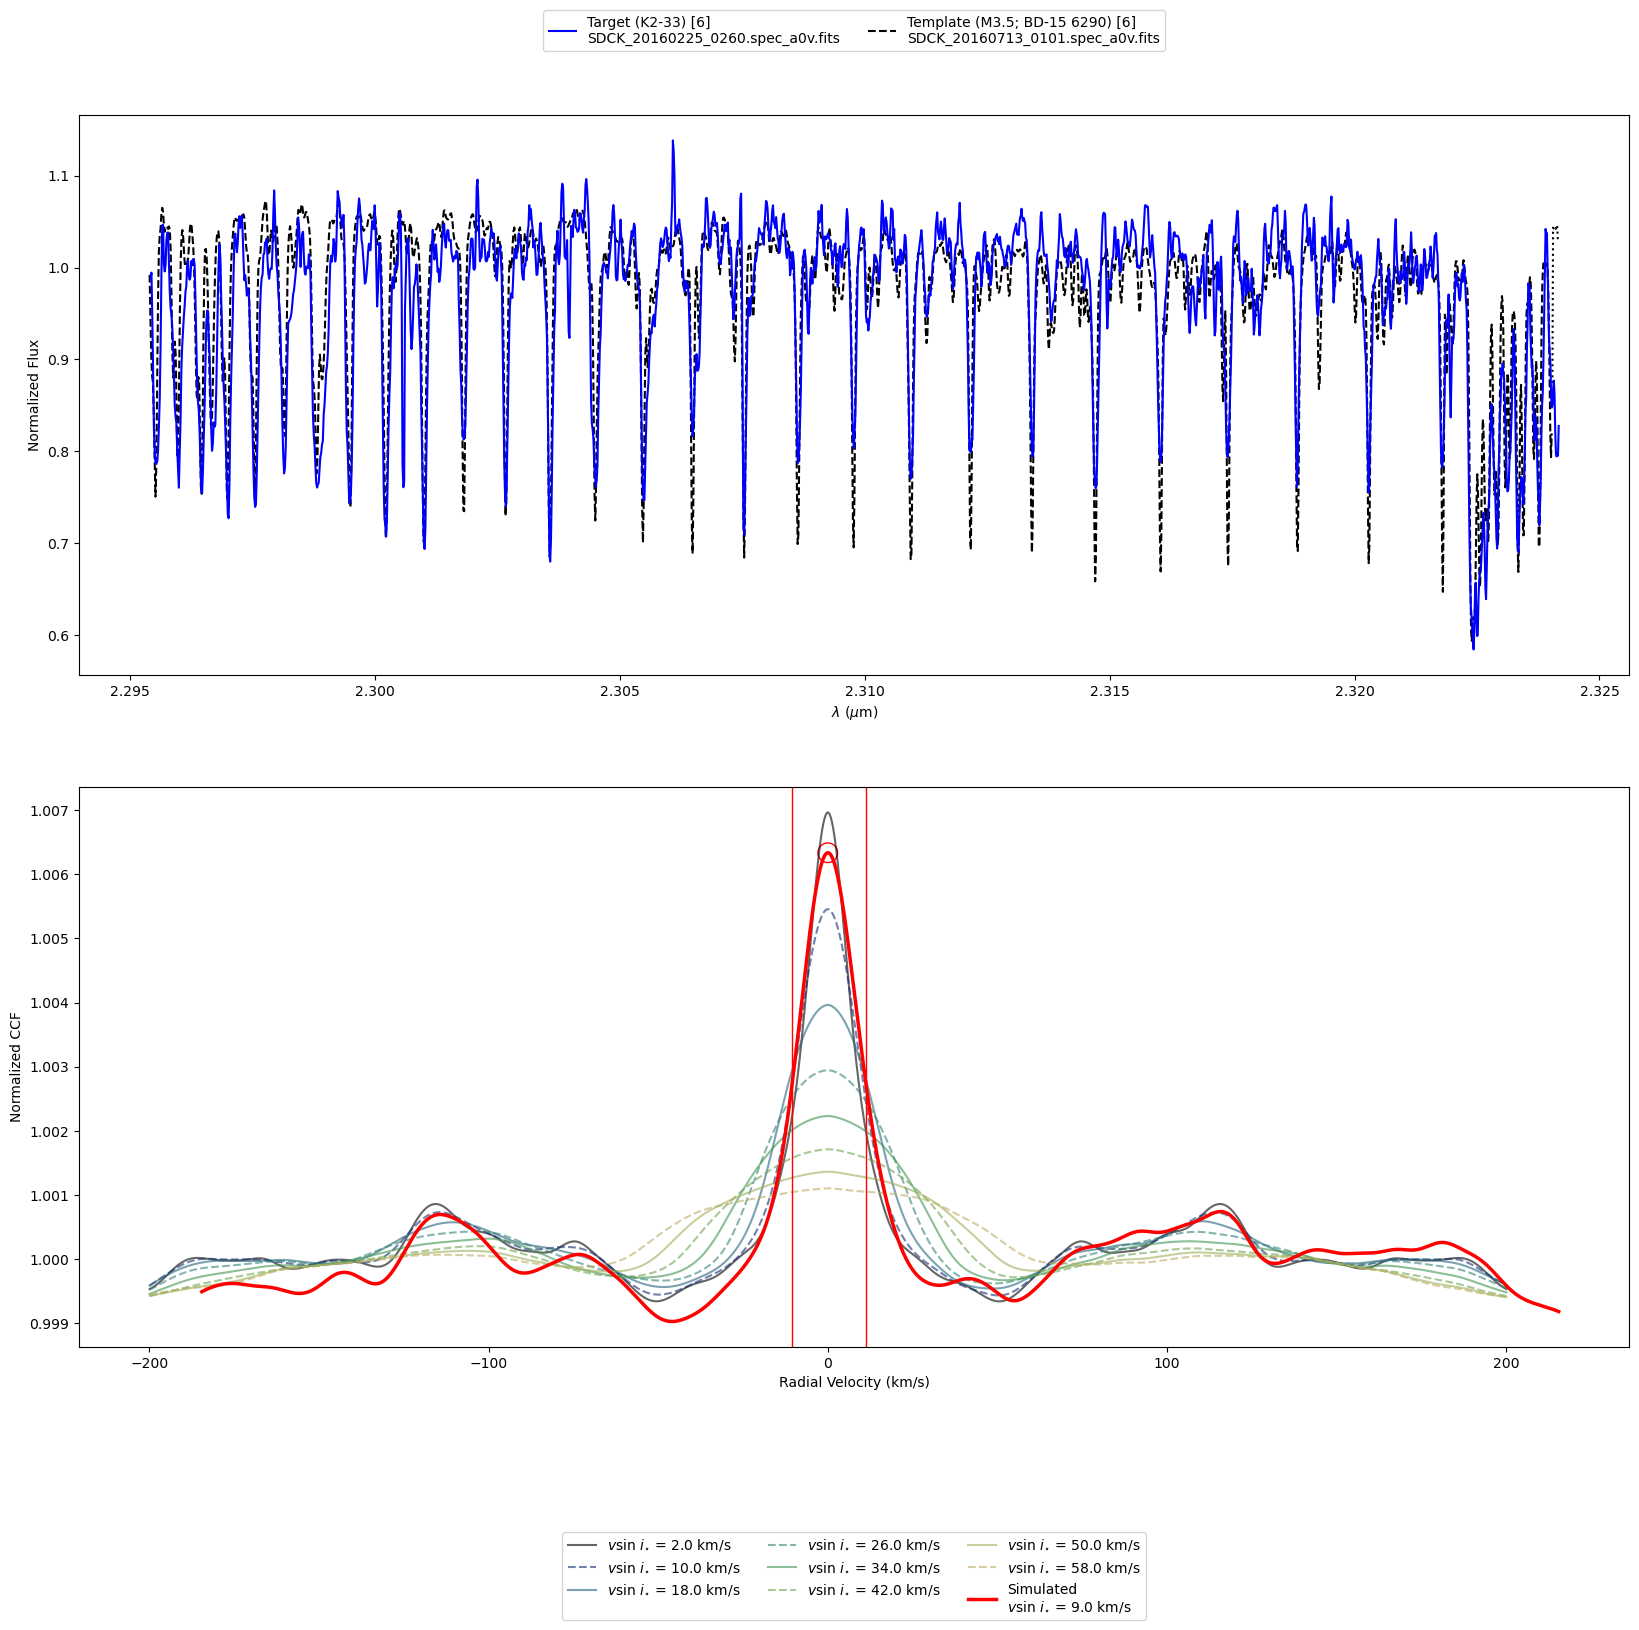

In [64]:
kwargs = dict(
    target_info=dict(
    	path=os.path.join("spectra", "K2-33_SDCK_20160225_0260.spec_a0v.fits"),
    	name="K2-33",
    	altname="",
    	other="SDCK_20160225_0260.spec_a0v.fits",
    ),
    # target_info=dict(
    # 	path=os.path.join("spectra", "K2-33_SDCK_20210510_0021.spec_a0v.fits"),
    # 	name="K2-33",
    # 	altname="",
    # 	other="SDCK_20210510_0021.spec_a0v.fits",
    # ),

    template_info=dict(
        path=os.path.join("spectra", "M3.5_BD-156290_SDCK_20160713_0101.spec_a0v.fits"),
        name="M3.5; BD-15 6290",
        other='SDCK_20160713_0101.spec_a0v.fits',
        limbdark_kwargs={'teff_tup': (3271, 157), 'logg': (4.8718, 0.0004)},
        ref="Stassun+2019"
    ),
    # template_info=dict(
    #     path=os.path.join("spectra", "M3.5_mu.02Her_SDCK_20140707_0095.spec_a0v.fits"),
    #     name="M3.5; mu.02 Her",
    #     other='SDCK_20140707_0095.spec_a0v.fits',
    #     limbdark_kwargs={'teff_tup': (3243, 98), 'r': 0.548, 'm': 0.600},
    #     ref="Stassun+2019"
    # ),
    
    savedir=os.path.join("output", "K2-33"),
    savekwargs=dict(
        folder='20160225',
        # folder='20210510',

        suffix='M3.5_BD-156290',
        # suffix='M3.5_mu.02Her',
    ),
    order=6,

    shift=-8,
    
    full_ccf=True,
    model=False,
    model_kwargs=dict(
        wave_correction=1e-4, # Angstrom --> micron
        peak_height=None # `None` if you want to see the spectrum with default peak-finding
    ),
    show_ccf_peak=True,
    
    diagnose_ccf=False
    # diagnose_ccf=True
)

if not os.path.isdir(kwargs['savedir']):
    os.mkdir(kwargs['savedir'])

make_fig(**kwargs)

In [63]:
## [4, 5, 6, 11, 12, 13, 14] ## -- a list of all the orders I consider
write_to_txt(
    [4, 5, 6, 14],
    kwargs['target_info'],
    kwargs['template_info'],
    kwargs['savedir'],
    savekwargs=kwargs['savekwargs'],
    log=True
)

In [66]:
def combined_result(target_info: dict, target_spectra: List[str], keys: List[str], savedir: str, upperlim=False, write=False):
    
    vsinilist, weightlist = list(), list()
    
    for spec in target_spectra:
        
        dir_ = os.path.join(savedir, spec)
        
        log = pd.read_csv(os.path.join(dir_, "_log.txt"), index_col='key')
        
        for key in keys:
            
            path = os.path.join(dir_, f"{key}.csv")
            
            orders = json.loads(log.loc[key, 'orders'])
            df = pd.read_csv(path, index_col='order').loc[orders]
            
            vsinilist.append(df['vsini'].values)
            weightlist.append(df['weight'].values)
            
    try:
        wt_mean, st_error = weighted_mean(np.array(vsinilist).flatten(), np.array(weightlist).flatten())
    except ValueError: # the arrays are not homogeneous sizes, i.e., one (or more) inconsistent orders
        wt_mean, st_error = weighted_mean([v for l in vsinilist for v in l], [w for l in weightlist for w in l])
        
    if upperlim:
        wt_mean = wt_mean + st_error
        st_error = np.nan
    
    if write:
        
        if upperlim:
            vsini_str = f"| vsini <= {wt_mean:.2f} km/s |"
            last_str = "(weighted mean + standard error of the weighted mean)"
            path = os.path.join(savedir, "combined_result_ul.txt")
        else:
            vsini_str = f"| vsini = {wt_mean:.2f} +/- {st_error:.2f} km/s |"
            last_str = "(weighted mean +/- standard error of the weighted mean)"
            path = os.path.join(savedir, "combined_result.txt")
        
        str_ = (
            f"Combined Result for {repr(target_info['name'])} ({repr(target_info['altname'])})"
            "\n\n"
            f"Spectra: {target_spectra}"
            "\n"
            f"Template Keys: {keys}"
            "\n\n"
            f'{"-"*len(vsini_str)}'
            "\n"
            f"{vsini_str}"
            "\n"
            f'{"-"*len(vsini_str)}'
            "\n\n"
            f"{last_str}"
        )
        
        with open(path, 'w') as f:
            f.write(str_)
    
    return wt_mean, st_error

Now we combine the results for different target spectra and templates into one quotable value. Set `upperlim=True` if the resulting plots looked reasonable, but orders' results were below the 2 km/s lower bound (their vsini would just be 2.0).

In [67]:
mean, error = combined_result(
    kwargs['target_info'],
    target_spectra=[
        '20160225',
        '20210510',
    ],
    keys=[
        'results-M3.5_BD-156290',
        'results-M3.5_mu.02Her',

        
    ],
    savedir=kwargs['savedir'],
    upperlim=False,
    write=True
)

mean, error

(7.655020775138644, 0.43713609021894334)

## Example With Model Spectrum

<div class="alert alert-block alert-info">
<b>Note:</b> This likely needs to be refined to get consistent results. Here, the model is not giving usable results, but this is the starting point for using a model template with this code.
</div>

LD coeff = 0.1
template FWHMs valid? True


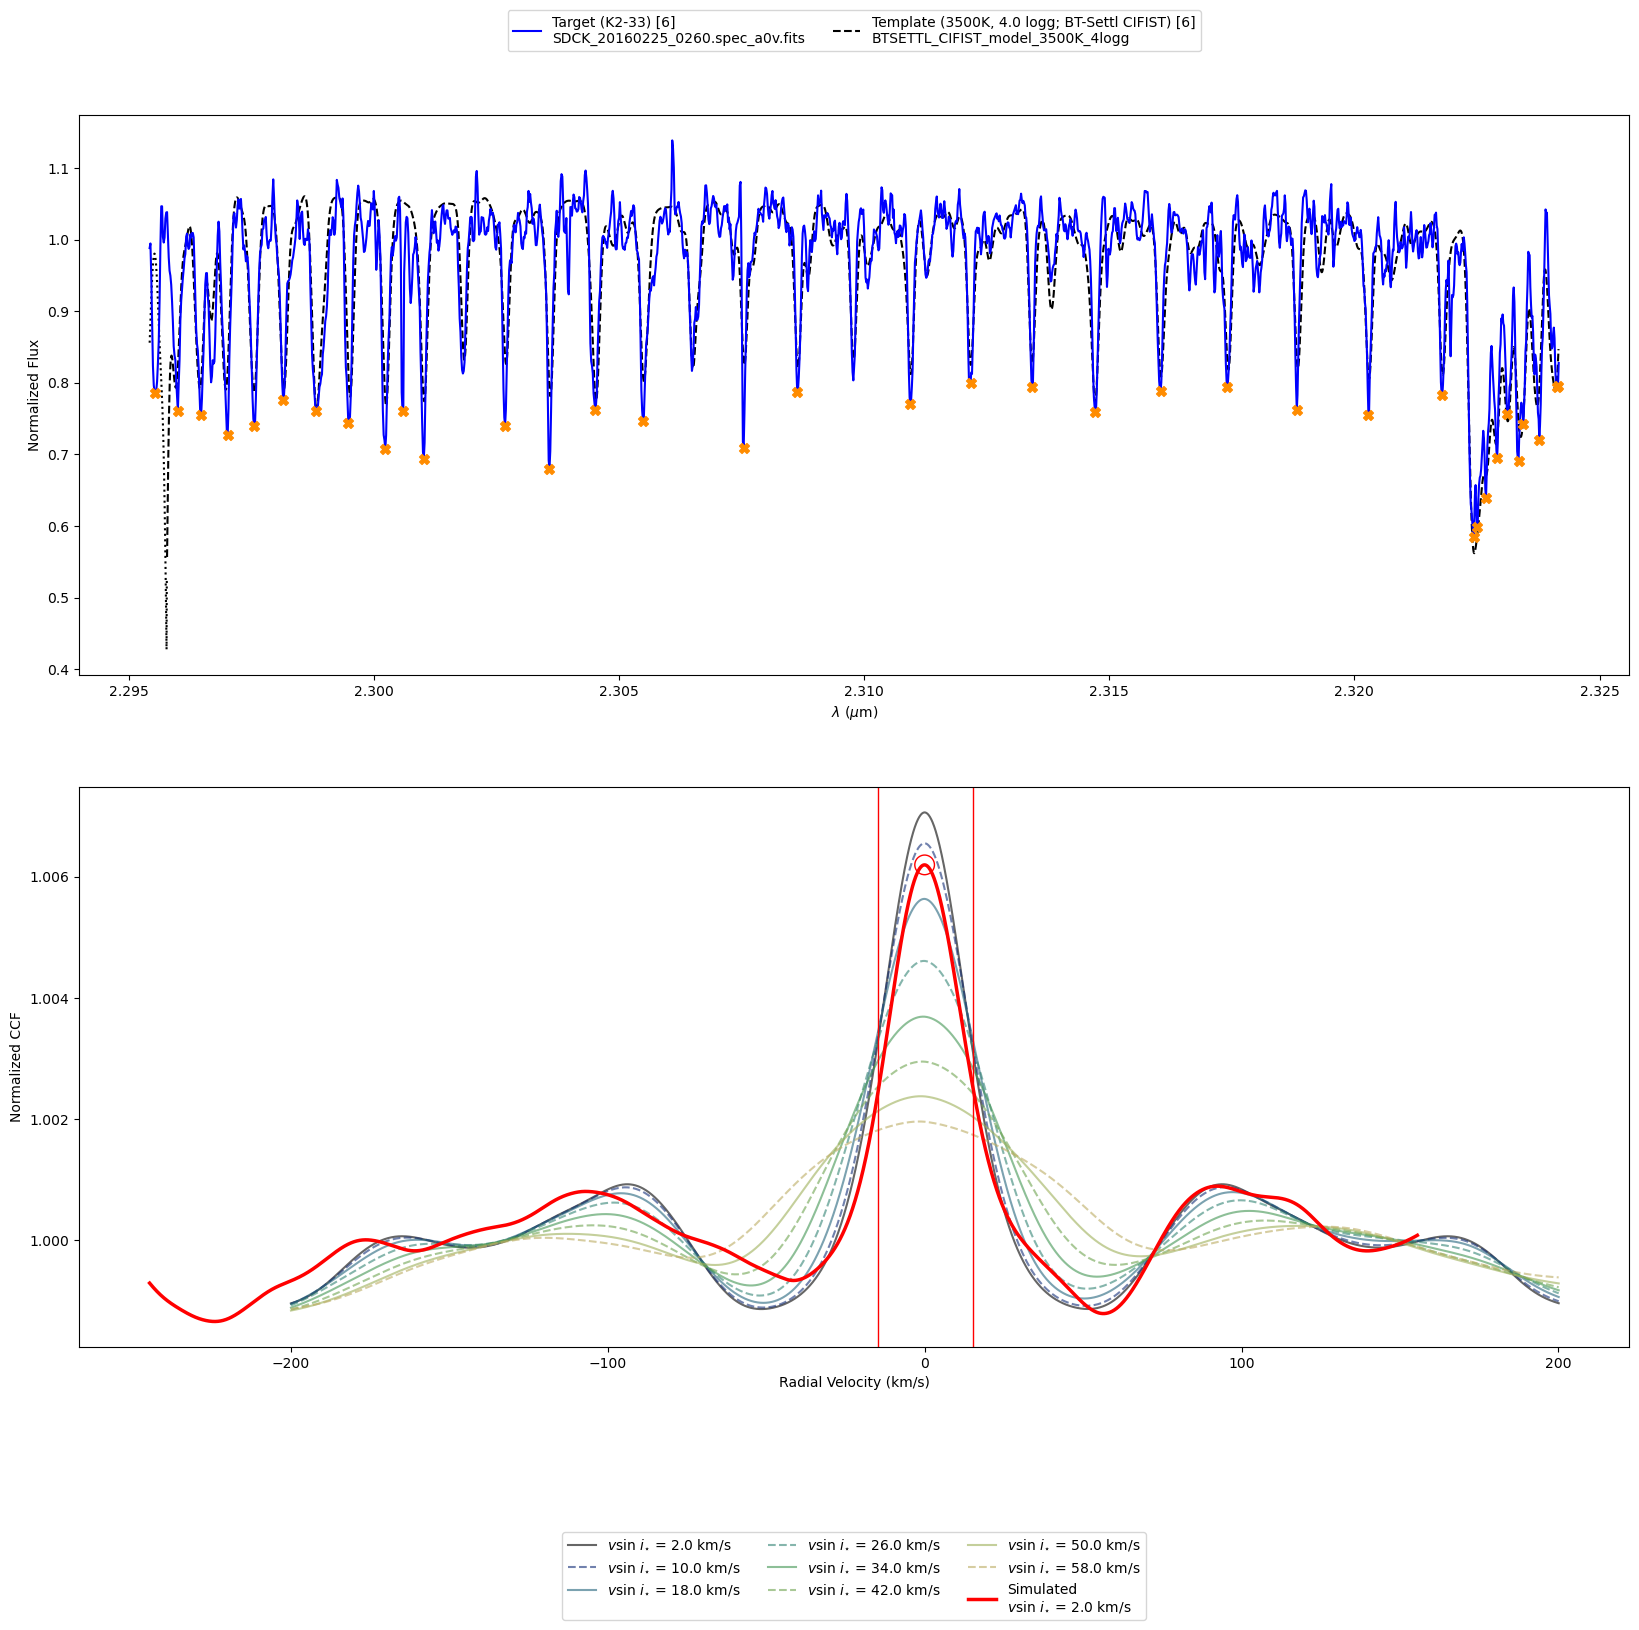

In [87]:
kwargs = dict(
    target_info=dict(
    	path=os.path.join("spectra", "K2-33_SDCK_20160225_0260.spec_a0v.fits"),
    	name="K2-33",
    	altname="",
    	other="SDCK_20160225_0260.spec_a0v.fits",
    ),

    template_info=dict(
        path=os.path.join("spectra", "BTSETTL_CIFIST_model_3500K_4logg.txt"),
        name="3500K, 4.0 logg; BT-Settl CIFIST",
        other='BTSETTL_CIFIST_model_3500K_4logg',
        limbdark_kwargs={'teff_tup': (3500, 0), 'logg': (4, 0)},
        ref=""
    ),
    
    savedir=os.path.join("output", "K2-33"),
    savekwargs=dict(
        folder='20160225',

        suffix='model_3500K_4logg',
    ),
    order=6,

    shift=70,
    
    full_ccf=True,
    model=True,
    model_kwargs=dict(
        wave_correction=1e-4, # Angstrom --> micron
        peak_height=0.8 # `None` if you want to see the spectrum with default peak-finding
    ),
    show_ccf_peak=True,
    
    diagnose_ccf=False
    # diagnose_ccf=True
)

if not os.path.isdir(kwargs['savedir']):
    os.mkdir(kwargs['savedir'])

make_fig(**kwargs)